In [ ]:
NO ESTA TERMINADO NADA DE ESTO PROFE, FAVOR NO CONSIDERAR EL DE LAS 12:00, falta toda la parte de visualizacion 

In [ ]:
#objetivo principal: clasificar en 4 clases: fondo, 1, 2, 3

In [ ]:
!git reset --hard && git pull

In [ ]:
#test passing blocks

### todo list: 

    - aplicar transformaciones al dataset
    - implementar early stopping
    - transfer learning resnet 50
    - evaluar ambos modelos 5 veces
    - obtener matriz de confusion y mostrar diferencias 
    - visualizar los diferentes entrenamientos 

In [2]:
%matplotlib notebook
%config IPCompleter.greedy=True
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
from PIL import Image
import os
import sys

# Datos 

In [ ]:
#esta balanceado???

In [2]:
!ls ./gestos/train/0 | wc -l
!ls ./gestos/train/1 | wc -l
!ls ./gestos/train/2 | wc -l
!ls ./gestos/train/3 | wc -l

!ls ./gestos/valid/0 | wc -l
!ls ./gestos/valid/1 | wc -l
!ls ./gestos/valid/2 | wc -l
!ls ./gestos/valid/3 | wc -l

2500
2500
2500
2500
500
500
500
500


In [ ]:
#sí, lo esta!, punto para nosotros...

### Transforms - Augmentation

In [3]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    #torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomRotation(degrees=30),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    #torchvision.transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3, fill=0),
    torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5,
                                       saturation=0.5, hue=0.0),
    torchvision.transforms.ToTensor()
    
])

### train data set and data loader

In [4]:
user = os.getenv('USER')
if (user == "felipesaldias"):
    ds_route= "./"
else: 
    ds_route= "/opt/data-nas/Fsaldias/"


In [5]:

train_dataset = torchvision.datasets.ImageFolder(f'{ds_route}gestos/train/', transform = transform)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=16, ##TODO: ajustar este tamaño
                                          shuffle=True,
                                          num_workers=4)


### test data set and data loader
lo unico que merece la pena la mecion aqui es que el batch lo intentamos hacer de 2000 para pasar todos los ejemplos de una y se caia por memoria vram

In [6]:
val_transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.ToTensor()
    ])

valid_dataset = torchvision.datasets.ImageFolder(f'{ds_route}gestos/valid', transform = val_transform)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                          batch_size=16, ##TODO: ajustar este tamaño
                                          shuffle=False,
                                          num_workers=4)


<IPython.core.display.Javascript object>


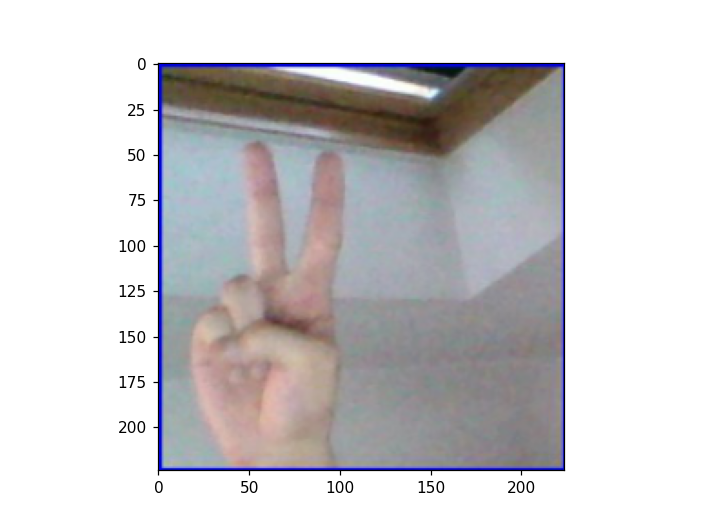

In [6]:
#bloque de comprension de donde queda la imagen 
iterable= iter(train_loader)
elemento_del_iterable = next(iterable) #contiene en el [0] los 16 ejemplos de las fotos y en el [1] las clases de estos
fig, ax = plt.subplots()
plt.imshow(elemento_del_iterable[0][1].numpy().transpose((1,2,0)))#.reshape(224,224,3))

# creacion del modelo

PROBAMOS VARIANDO NEURONAS, VARIANDO EL MAXPOOL, TENIENDO TANTAS COSAS QUE CONTROLAR UNO PREFIERE OBVIAR ALGUNAS Y NOS CONCENTRAMOS EN PROBAR DIFERENTES COMBINACIONES DE CAPAS.

al manipular capas fc, poniendo capas intermedias entre las arquitectura lenet5 clasica y nuestra propuesta no pudimos conseguir mejores resultados 


principalmente variamos las capas convolucionales y jugamos con algunas sin max pooling, para evaluar, puede encontrar algunas referencias que anotamos en el cuaderno anexo1.pdf, al aumentar las capas convolucionales en una y dos se podria tender a pensar que los resultados eran mejores, pero al intentar probar con 5 capas convolucionales se obtuvieron resultados peores

In [9]:
class OTT_Classifier(torch.nn.Module):
    
    def __init__(self):
        super(OTT_Classifier, self).__init__()
        self.conv1 = torch.nn.Conv2d(kernel_size=4, in_channels=3, out_channels=6)
        self.conv2 = torch.nn.Conv2d(kernel_size=4, in_channels=6, out_channels=16)
        self.conv3 = torch.nn.Conv2d(kernel_size=4, in_channels=16, out_channels=32)
        self.conv4 = torch.nn.Conv2d(kernel_size=4, in_channels=32, out_channels=64)

        self.mpool = torch.nn.MaxPool2d(kernel_size=2)
        self.activation = torch.nn.ReLU()#torch.nn.LeakyReLU()
        self.activation2 = torch.nn.Softmax(dim=1)
        self.linear1 = torch.nn.Linear(in_features=64*11*11 ,out_features=120)
        self.linear2 = torch.nn.Linear(in_features=120 ,out_features=84)
        self.linear3 = torch.nn.Linear(in_features=84 ,out_features=4)
        
        pass
                     
    def forward(self, x):
        h = self.mpool((self.activation(self.conv1(x))))
        h = self.mpool((self.activation(self.conv2(h))))
        h = self.mpool((self.activation(self.conv3(h))))
        h = self.mpool((self.activation(self.conv4(h))))
        #print(h.shape)
        h = h.view(-1, self.linear1.in_features)
        h = self.activation(self.linear1(h))
        h = self.activation(self.linear2(h))
        h = self.activation2(self.linear3(h))
        return h
                     
                    
                     
#hacer pasar un ejemplo 
#image = torch.tensor(np.zeros((1,3,200,200)), dtype= torch.float32) #fake example
model = OTT_Classifier()       
display((model.forward(valid_dataset[1][0].unsqueeze(0)).argmax(dim=1).detach().numpy())[0])

    
                     

1

# Entrenamiento

 La eleccion del criterio es casi algo obligatorio ya que al ser nuestro objetivo una clasificacion multiclase debemos utilizar la CrossEntropyLoss 
 
 En cuanto al optimizador, se opto por Adam por ser la primera red convolucional que estamos desarrollando y se ve que es muy utilizado en la literatura, preferimos no complicarnos en esto teniendo tanto que ajustar. como el learning rate del optimizador que solo a prueba y error variandolo se opto por quedarnos con el mismo que habiamos comenzando 

In [ ]:
import time
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def please_train_it(name, epochs):

    max_epochs = epochs
    torch.manual_seed(1234) # Inicialización

    model = OTT_Classifier()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss(reduction='sum') #debido a la clasificacion multiclase

    #to device
    device = torch.device('cuda:0')
    model = model.to(device)


    def train_one_step(batch):#batch):
        optimizer.zero_grad()
        x, y = batch
        x, y = x.to(device), y.to(device)
        yhat = model.forward(x)
        loss = criterion(yhat, y)
        loss.backward()
        optimizer.step()
        return loss.item() 
    
    
    def evaluate_one_step(x, y):
        with torch.no_grad():
            #x, y = batch
            x, y = x.to(device), y.to(device)
            yhat = model.forward(x)
            loss = criterion(yhat, y)
            return y, yhat, loss.item()
    
        
    def log_results(name, epochs, loss, valid_accuracy, best_epoch,
                    best_valid_loss, best_valid_loss_accuracy, 
                    best_valid_loss_accuracy_by_class, time): 
        original_stdout = sys.stdout
        with open(f'./logs/{name}_logs.txt', "w", encoding="utf-8") as file:
            sys.stdout = file
            print("Nombre: ", name)
            print("Epoch", "Train_loss", "Val_loss", "gral_accuracy")
            index= np.append(np.arange(0, epochs).reshape(epochs,1), loss, axis=1)
            data= np.append(index, valid_accuracy.reshape(epochs,1), axis= 1)
            print(data)
            print("your train takes around : ", time, "seconds")
            print("the best val_loss was in epoch :", best_epoch)
            print("con una loss de: ", best_valid_loss)
            print("y una presicion gral de : ", best_valid_loss_accuracy)
            print("y una presicion por clase de : ", best_valid_loss_accuracy_by_class)
            print("______________________________________")
            
            sys.stdout = original_stdout

    
    writer = SummaryWriter(log_dir=f'/tmp/tensorboard/run{time.time_ns()}')
    
    #criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
    running_loss = np.zeros(shape=(max_epochs, 2))
    valid_accuracy = np.zeros(max_epochs)
    best_valid_loss = np.inf
    best_valid_loss_accuracy = 0.
    best_valid_loss_accuracy_by_class = np.zeros(4)
    best_epoch= -1
    best_y= 0
 

    ##entrenamiento 
    t= time.time()
    for epoch in range(max_epochs):
    
        t1= time.time()
        train_loss, valid_loss = 0.0, 0.0
    
        #model.train()
        for batch in train_loader:
            # model.train()
            train_loss += train_one_step(batch)
        running_loss[epoch, 0] = train_loss/train_loader.dataset.__len__()   
        writer.add_scalar("Loss/train", train_loss, epoch)
    
        # Loop de validación
        y_pred = []
        y_true = []

        for samples, tags in valid_loader:

            y, yhat, loss= evaluate_one_step(samples, tags)
            
            y_true.append(y.cpu())
            y_pred.append(yhat.cpu().argmax(dim=1).detach().numpy())
            valid_loss += loss
            
        
        y_pred = np.concatenate(y_pred) #aplana todo a en una dim 
        y_true = np.concatenate(y_true)
    
        if((valid_dataset.targets == y_true).all):
            print("equals")
        val_loss = valid_loss/valid_loader.dataset.__len__()  
        accuracy = accuracy_score(y_true, y_pred)
        print("Accuracy: ", accuracy)
        #display(y_pred)
        
        
        # accuracy by class
        matrix = confusion_matrix(y_true, y_pred)
        print("Accuracy by class: ",matrix.diagonal()/matrix.sum(axis=1))
        
        #guardamos todas las variables que queremos
        valid_accuracy[epoch]= accuracy 
        running_loss[epoch, 1] = val_loss    
        writer.add_scalar("valid/loss", val_loss, epoch)
        writer.add_scalar("valid/accuracy", accuracy, epoch)
    
    
        # Guardar modelo si es el mejor hasta ahora    
        if val_loss < best_valid_loss:
            print("best_valid_loss replaced: ", val_loss)
            best_epoch=epoch
            best_valid_loss = val_loss
            best_valid_loss_accuracy = accuracy
            matrix = confusion_matrix(y_true, y_pred)
            best_valid_loss_accuracy_by_class= matrix.diagonal()/matrix.sum(axis=1)
            best_y = y_pred
        
            
            torch.save({'current_epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'current_valid_loss': valid_loss
                       }, f'{name}best_model.pt')
            
        print(time.time()-t1)
        
        print("ENDDDDDDD EPOCH") 
    log_results(name, max_epochs, running_loss, valid_accuracy, best_epoch, best_valid_loss, 
                best_valid_loss_accuracy, best_valid_loss_accuracy_by_class, time.time()-t
               )
    return best_y



# Evaluacion del modelo 


decidimos no cargar los pesos nuevamente aqui y en vez de esto, manejar todo en memoria para no tener que estar reconstruyendo el modelo con los mejores pesos antes de evaluar, se mantienen los datos de la mejor epoca (con menor accuracy)

In [36]:
import pandas as pd

In [130]:

arreglo = [None] * 5
medias = [None] * 5
y_true=valid_dataset.targets 

for i in range(5):
    y_pred = please_train_it(f"EXPERIMENT:{i}", 5)
    #y_pred = [2,2,2,2,3,3,3]
    metrics = precision_recall_fscore_support(y_true, y_pred)
    df =pd.DataFrame(metrics, columns=["0", "1", "2", "3"], index=["precision", "recall", "fscore", "support"])
    series_medias= pd.Series(df.mean(axis=1),name= "media")
    df_mean= pd.concat([df,series_medias],axis= 1)
    arreglo[i] = df_mean
    medias[i] = series_medias
df= pd.concat(arreglo, axis=0, keys=range(5))
display(df)
mean = pd.concat(medias, axis=1, keys=range(5)).mean(axis=1)
std = pd.concat(medias, axis=1, keys=range(5)).std(axis=1)

TypeError: please_train_it() takes 0 positional arguments but 2 were given

## Graficando 

<IPython.core.display.Javascript object>


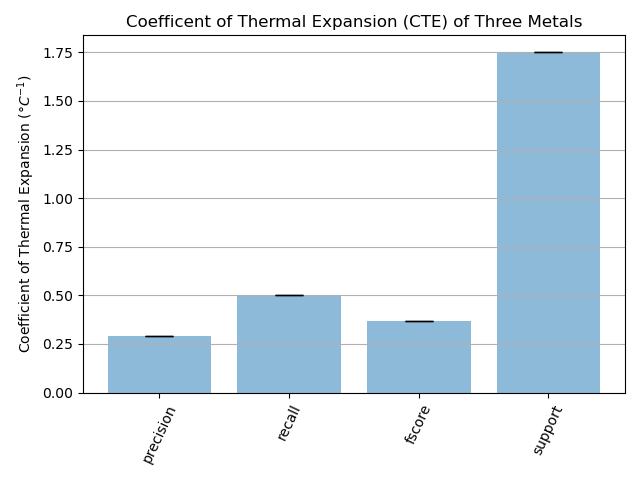

In [129]:
fig, ax = plt.subplots()
ax.bar(range(4), mean.values, yerr=std.values, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Coefficient of Thermal Expansion ($\degree C^{-1}$)')
ax.set_xticks(range(4))
#ax.set_xticklabels(materials)
ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
ax.yaxis.grid(True)

#ax.set_xticks(idx)
ax.set_xticklabels(["precision", "recall", "fscore", "support"], rotation=65)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()


In [85]:
pd.concat(arreglo, axis=0, keys=range(5))

0         1         2    3     media
0 precision  0.0  0.500000  0.666667  0.0  0.291667
  recall     0.0  1.000000  1.000000  0.0  0.500000
  fscore     0.0  0.666667  0.800000  0.0  0.366667
  support    2.0  2.000000  2.000000  1.0  1.750000
1 precision  0.0  0.500000  0.666667  0.0  0.291667
  recall     0.0  1.000000  1.000000  0.0  0.500000
  fscore     0.0  0.666667  0.800000  0.0  0.366667
  support    2.0  2.000000  2.000000  1.0  1.750000
2 precision  0.0  0.500000  0.666667  0.0  0.291667
  recall     0.0  1.000000  1.000000  0.0  0.500000
  fscore     0.0  0.666667  0.800000  0.0  0.366667
  support    2.0  2.000000  2.000000  1.0  1.750000
3 precision  0.0  0.500000  0.666667  0.0  0.291667
  recall     0.0  1.000000  1.000000  0.0  0.500000
  fscore     0.0  0.666667  0.800000  0.0  0.366667
  support    2.0  2.000000  2.000000  1.0  1.750000
4 precision  0.0  0.500000  0.666667  0.0  0.291667
  recall     0.0  1.000000  1.000000  0.0  0.500000
  fscore     0.0  0.666667  0.800000  0.0  0.366667
  support    2.0  2.000000  2.000000  1.0  1.750000

In [38]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support 

y_true=[1,1,2,2,3,3,4] 
y_pred=[2,2,2,2,3,3,3]




In [43]:
precision

array([0.        , 0.5       , 0.66666667, 0.        ])

In [53]:
df.mean(axis=1)

precision    0.291667
recall       0.500000
fscore       0.366667
support      1.750000
dtype: float64

In [72]:

arreglo[0]= df

In [73]:


metrics = precision_recall_fscore_support(y_true, y_pred)
df =pd.DataFrame(metrics, columns=["0", "1", "2", "3"], index=["precision", "recall", "fscore", "support"])
pd.concat([df,pd.Series(df.mean(axis=1),name= "media")],axis= 1)


/home/felipesaldias/.conda/envs/AI3.7/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0,1,2,3,media
precision,0.0,0.500000,0.666667,0.0,0.291667
recall,0.0,1.000000,1.000000,0.0,0.500000
fscore,0.0,0.666667,0.800000,0.0,0.366667
support,2.0,2.000000,2.000000,1.0,1.750000


# Discusión preliminar
En general se ve como al modelo le cuesta siempre mucho mas reconocer la clase 3 (3 dedos) por sobre las clases restantes, es experto en reconocer nada, y al decir nada no nos referimos a nada, si no que a la ausencia de manos de la clase 0

In [ ]:
# TODO: dataframes bonitos con las comparaciones y links a los pesos finales de los modelos 

# TRANSFER LEARNING

# resnet 50
https://www.kaggle.com/pmigdal/transfer-learning-with-resnet-50-in-pytorch

In [28]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform= transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
    ])

train_dataset = torchvision.datasets.ImageFolder(f'{ds_route}gestos/train/', transform = transform)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=16, ##TODO: ajustar este tamaño
                                          shuffle=True,
                                          num_workers=4)


In [29]:
max_epochs= 10
device = torch.device('cuda:0')
def please_launch_transfer_learning(name):
    
    best = {
        "y_pred": 0,
        "valid_loss": 0,
        "accuracy": 0
    }
    
    best_valid_loss = np.inf
    model = torchvision.models.resnet18(pretrained=True)

    #Congelamos todos los parámetros
    for param in model.parameters(): 
        param.requires_grad = False

    # Recuperamos el número de neuronas de la última capa
    neurons = model.fc.in_features 
    # La reemplazamos por una nueva capa de salida
    model.fc = torch.nn.Linear(neurons, 4) 
    #model.fc = torch.nn.Sequential(
    #           torch.nn.Linear(neurons, 4),
    #           torch.nn.Softmax(dim=1)).to(device)
    model = model.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    
    for epoch in range(max_epochs):
        #train the model
        model.train()
        for x, y in train_loader:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            yhat = model.forward(x)
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()
        
        #eval the model    
        y_pred = []
        epoch_loss = 0.0
        model.eval()
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            yhat = model.forward(x)
            y_pred.append(yhat.cpu().argmax(dim=1).detach().numpy())
            loss = criterion(yhat, y)
            epoch_loss += loss.item()
        y_pred = np.concatenate(y_pred)
        val_loss= epoch_loss/valid_loader.dataset.__len__()
        ###########
        accuracy = accuracy_score(valid_dataset.targets, y_pred)
        print("Accuracy: ", accuracy)
        print(epoch, epoch_loss/valid_loader.dataset.__len__() )
        ############
        ## save it if is better
        if val_loss < best_valid_loss:
            print("best_valid_loss replaced: ", epoch_loss/valid_loader.dataset.__len__())
            best["y_pred"] = y_pred #si guardamos esto evitamos tener que cargar los mejores pesos solamente para evaluar y sacar las metricas
            best["valid_loss"] = epoch_loss/valid_loader.dataset.__len__()
            best["accuracy"] = accuracy_score(valid_dataset.targets, y_pred)
            best_valid_loss = epoch_loss/valid_loader.dataset.__len__()
            
            torch.save({'current_epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'current_valid_loss': epoch_loss/valid_loader.dataset.__len__()
                       }, f'{name}_TL_best_model.pt')
            
    return best

In [30]:
please_launch_transfer_learning()

Accuracy:  0.366
0 0.0884957705885172
best_valid_loss replaced:  0.0884957705885172
Accuracy:  0.491
1 0.07151644886774011
best_valid_loss replaced:  0.07151644886774011


KeyboardInterrupt: 

In [ ]:
#bibliografia

#apis
https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder
    
    
#tutoriales

https://medium.com/jun-devpblog/pytorch-1-transform-imagefolder-dataloader-7f75f0a460c0
    https://www.kaggle.com/androbomb/using-cnn-to-classify-images-w-pytorch 
        https://towardsdatascience.com/transfer-learning-picking-the-right-pre-trained-model-for-your-problem-bac69b488d16
            https://www.kaggle.com/pintu161/transfer-learning-in-pytorch-using-resnet18
                https://www.kaggle.com/pmigdal/transfer-learning-with-resnet-50-in-pytorch
                    https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html #accuracy
                        https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
                